<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture8/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">COMP6252 Deep Learning Technologies</h1>
<h2 style="text-align: center;"> Transfer Learning</h2>

## Download data

In [ ]:
import sys,os
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import files
  file=files.upload()
  %mkdir /root/.kaggle
  %mv kaggle.json  /root/.kaggle

if not os.path.exists("flowers-recognition.zip"):
   !kaggle datasets download -d alxmamaev/flowers-recognition

if not os.path.isdir("flowers"):
   !unzip flowers-recognition.zip >/dev/null

  

#### Usual imports

In [2]:
import getpass
import os
try:
  import comet_ml
except ModuleNotFoundError:
  %pip install comet_ml
  import comet_ml
comet_api_key=os.environ.get("COMET_API_KEY")
if comet_api_key is None:
  comet_api_key=getpass.getpass("Enter key")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import  transforms
from torch.utils.data import Dataset,DataLoader,random_split
import matplotlib.pyplot as plt
import copy

In [4]:
try:
        import timm
except:
        %pip install timm==0.4.12
        import timm

In [5]:
WHERE_TO_GET_MODEL='hub'# options: 'timm','torchvision','hub'
last_layer_only=False

In [6]:
seed=9797 
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True


### Create custom dataset class

- Since we use ```random_split``` we cannot use different transforms to the training and validation datasets
- Dataset is an abstract class. It cannot be instantiated 
- We need to wrap the datasets obtained from ```random_split``` with a custom dataset class

In [7]:
class MyDataset(Dataset):
    def __init__(self,subset,transform=None):
        self.subset=subset
        self.transform=transform
    def __getitem__(self,idx):
        x,y=self.subset[idx]
        if self.transform:
            x=self.transform(x)
        return x,y
    def __len__(self):
        return len(self.subset)

#### Data augmentation


In [8]:
augment_choices={'trivial':transforms.TrivialAugmentWide(),'random':transforms.RandAugment(),
                 'mix':transforms.AugMix(),'auto':transforms.AutoAugment()}
aug='trivial'

In [9]:
data_transforms = {
     'train':  transforms.Compose([ transforms.CenterCrop(224),transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [.5, .5, .5])
    ]) if aug=='None' else
     
     transforms.Compose([ transforms.TrivialAugmentWide(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [.5, .5, .5])
    ]), 
  
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [.5, .5, .5])
    ])
}



- Why did we choose 224? 
- Because most models are pre-trained on the ImageNet dataset
- Which uses image sizes of 224x224

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


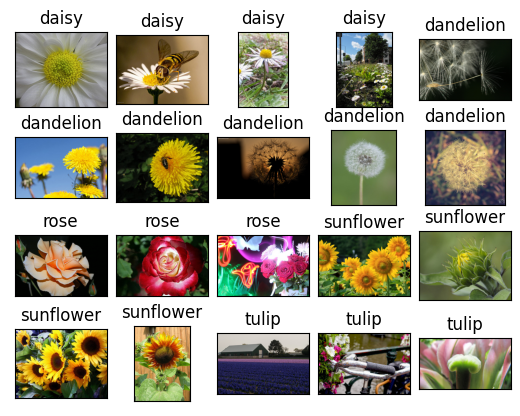

In [10]:
dataset=torchvision.datasets.ImageFolder("flowers")
class_names=dataset.classes
print(class_names)
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=.1, hspace=.3)
for i in range(20):
            #img,label=next(itr)
            img,label=dataset[i*200]
            t=fig.add_subplot(4,5,i+1)
            # set the title of the image equal to its label
            t.set_title(class_names[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img)

In [11]:

train_d,valid_d=random_split(dataset,lengths=[0.8,0.2])

datasets={'train':train_d,'val':valid_d}
image_datasets = {x: MyDataset(datasets[x],data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x=='train' else False, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### What models are available?

In [12]:
list_of_models=torchvision.models.list_models()
resnets=[m for m in list_of_models if 'resnet' in m]

In [13]:
timm_models=timm.list_models()
timm_resnets=[m for m in timm_models if 'resnet' in m]

In [14]:
model=timm.create_model('resnet18',pretrained=True)
print(list(model.named_modules())[-1])
model.reset_classifier(10)
print(list(model.named_modules())[-1])

('fc', Linear(in_features=512, out_features=1000, bias=True))
('fc', Linear(in_features=512, out_features=10, bias=True))


In [15]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
print(list(model.named_modules())[-1])

('fc', Linear(in_features=512, out_features=1000, bias=True))


In [16]:
comet_ml.init(project_name="flower-classification")
experiment=comet_ml.Experiment(api_key=comet_api_key)

COMET INFO: Comet API key is valid
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hikmat-farhat-gmail-com/flower-classification/9c921d3bc998463cb8c789836442a174



#### Evaluation function

In [17]:

def evaluate(model, criterion):
    with torch.no_grad():
        model.eval()   
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects.double() / dataset_sizes['val']
    return epoch_loss,epoch_acc

#### Training loop

In [18]:
def train_model(model, criterion, optimizer,scheduler=None, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()  
        running_loss,running_corrects =0.0, 0
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
       
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if scheduler != None:
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        v_loss,v_acc=evaluate(model,criterion)
        experiment.log_metrics({"train_loss":epoch_loss,"train_acc":epoch_acc},epoch=epoch)

        experiment.log_metrics({"val_loss":v_loss,"val_acc":v_acc},epoch=epoch)
        if  v_acc > best_acc:
                best_acc = v_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if epoch%5==0:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            
            print("t_loss={:.4f},t_acc={:.4f}".format(epoch_loss,epoch_acc))
            print("v_loss={:.4f},v_acc={:.4f}".format(v_loss,v_acc))
    ## training is done. Return the model with the best validation accuracy
    model.load_state_dict(best_model_wts)
    return model

### Train the last layer only

IMPORTANT: for ```huggingface/pytorch-image-models``` one must install huggingface_hub. 
Also some versions of timm are incompatible with torch hub. The culprit is usually cached models
in ```.cache/torch/hub/```

For vision timm almost surely has what you need. In case you need models for other applications or non-standard models
torch hub is more flexible. The main function is ```torch.hub.load(githubURL,model)``` 

In [19]:
if WHERE_TO_GET_MODEL=='timm':
    
    #model_name='resnet18'
    model_name='vit_base_patch16_224'
    #model_name='deit_base_patch16_224'
    model=timm.create_model(model_name=model_name,pretrained=True)
    if last_layer_only:
        for p in model.parameters():
            p.requires_grad=False

    model.reset_classifier(len(class_names))

elif WHERE_TO_GET_MODEL=='torchvision':
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    nfeatures = model.fc.in_features
    if last_layer_only:
        for p in model.parameters():
            p.requires_grad=False
    model.fc = nn.Linear(nfeatures, len(class_names))

else:
    model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
    #model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
    #model = torch.hub.load('huggingface/pytorch-image-models', 'vit_base_patch16_224', pretrained=True)
    if last_layer_only:
        for p in model.parameters():
            p.requires_grad=False
    
    nfeatures = model.fc.in_features
    ### HuggingFace models have a standardized output interface
    ### When using Hub one needs to go case by case
    #nfeatures = model.fc.in_features
    model.fc = nn.Linear(nfeatures, len(class_names))
    #model.reset_classifier(len(class_names))



optimizer= optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cache found in /home/user/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/user/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/user/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [20]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

In [21]:
model= train_model(model, criterion, optimizer,scheduler=scheduler,num_epochs=10)


Epoch 0/9
----------
t_loss=0.9245,t_acc=0.6917
v_loss=0.4284,v_acc=0.8725
Epoch 5/9
----------
t_loss=0.2119,t_acc=0.9247
v_loss=0.2052,v_acc=0.9328


#### Saving  a PyTorch model
- In reality we save the weights
- Saving the model as a whole is also possible but could break easily
- Preference for the first method

In [22]:
torch.save(model.state_dict(),"last-only-weights")

- The weights can be loaded as follows
- Note that the model needs to be instantiated first

In [23]:

model.load_state_dict(torch.load("last-only-weights"))

<All keys matched successfully>